In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import STL
from utilsforecast.plotting import plot_series

from statsforecast import StatsForecast
from coreforecast.scalers import boxcox, boxcox_lambda
from statsmodels.tsa.seasonal import seasonal_decompose

from plotnine import *

# change working directory 
# Check if current directory has any .ipynb files
if any(fname.endswith(".ipynb") for fname in os.listdir()):
    os.chdir("..")

# load local package modules
from gas_pump_prices.preprocess import * 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup
Code below reads in historical gas prices and weekly CPI data. Data are then filered for unleaded gasoline prices in Toronto and prices are rebased to 2025 dollars using the following equation: 

$$
\text{Price}_{2025 dollars} = \frac{\text{CPI}}{CPI_{2025}} * \text{price}
$$

In [ ]:
df_gas = pd.read_csv('data/raw/fueltypesall.csv')

# convert date to datetime object 
df_gas['Date'] = pd.to_datetime(df_gas['Date'])
df_gas.drop('Type de carburant', axis=1, inplace=True)

# convert to long format 
df_gas = pd.melt(frame=df_gas, id_vars=['Date', 'Fuel Type'], 
        var_name='city',value_name='price')
df_gas = df_gas.query(
    "city == 'Toronto East/Est' &  `Fuel Type` == 'Regular Unleaded Gasoline'")

# read in inflation data
df_inflation = pd.read_csv('data/raw/1810000401_databaseLoadingData.csv')
df_inflation.columns = df_inflation.columns.str.lower()
df_gas_inf = df_inflation.query("`products and product groups` == 'Gasoline'").copy()
                                   
# compute dollars in terms of 2025 dollars
# 1) Compute CPIs centered on 2025
value_25 = df_gas_inf.query('ref_date == "2025-06"')['value']
df_gas_inf['cpi_2025'] = value_25.values/df_gas_inf['value']

# merge in CPI value based on year-month and compute 
df_gas['year_month'] = df_gas["Date"].dt.strftime("%Y-%m")
df_gas_inf["ref_date"] = pd.to_datetime(df_gas_inf["ref_date"])
df_gas_inf['date_ymw'] = df_gas_inf["ref_date"].dt.strftime("%Y-%m")

cols = ['date_ymw', 'value', 'cpi_2025']
df_gas = pd.merge(left=df_gas, right=df_gas_inf[cols],
                  left_on='year_month', right_on='date_ymw', how='left')


# NOTE: replace 1990-01 with 1990-02 and 2025-07 with 2025-06
df_gas.loc[df_gas['year_month'].eq("1990-01"), 'cpi_2025'] = df_gas.loc[df_gas['year_month'].eq("1990-02"), 'cpi_2025'].iloc[0]
df_gas.loc[df_gas['year_month'].eq("2025-07"), 'cpi_2025'] = df_gas.loc[df_gas['year_month'].eq("2025-06"), 'cpi_2025'].iloc[0]

assert (df_gas['cpi_2025'].isna().sum() == 0), '''Check missing cpi_2025 values'''

# compute price adjusted metrics 
df_gas['price_2025'] = df_gas['price'] * df_gas['cpi_2025']

assert (df_gas['price_2025'].isna().sum() == 0), '''Check missing price_2025 values'''

# create toronto data
df_toronto = df_gas.query("city == 'Toronto East/Est'" )
df_toronto.to_csv('data/processed/data_toronto_proc.csv', index=False)

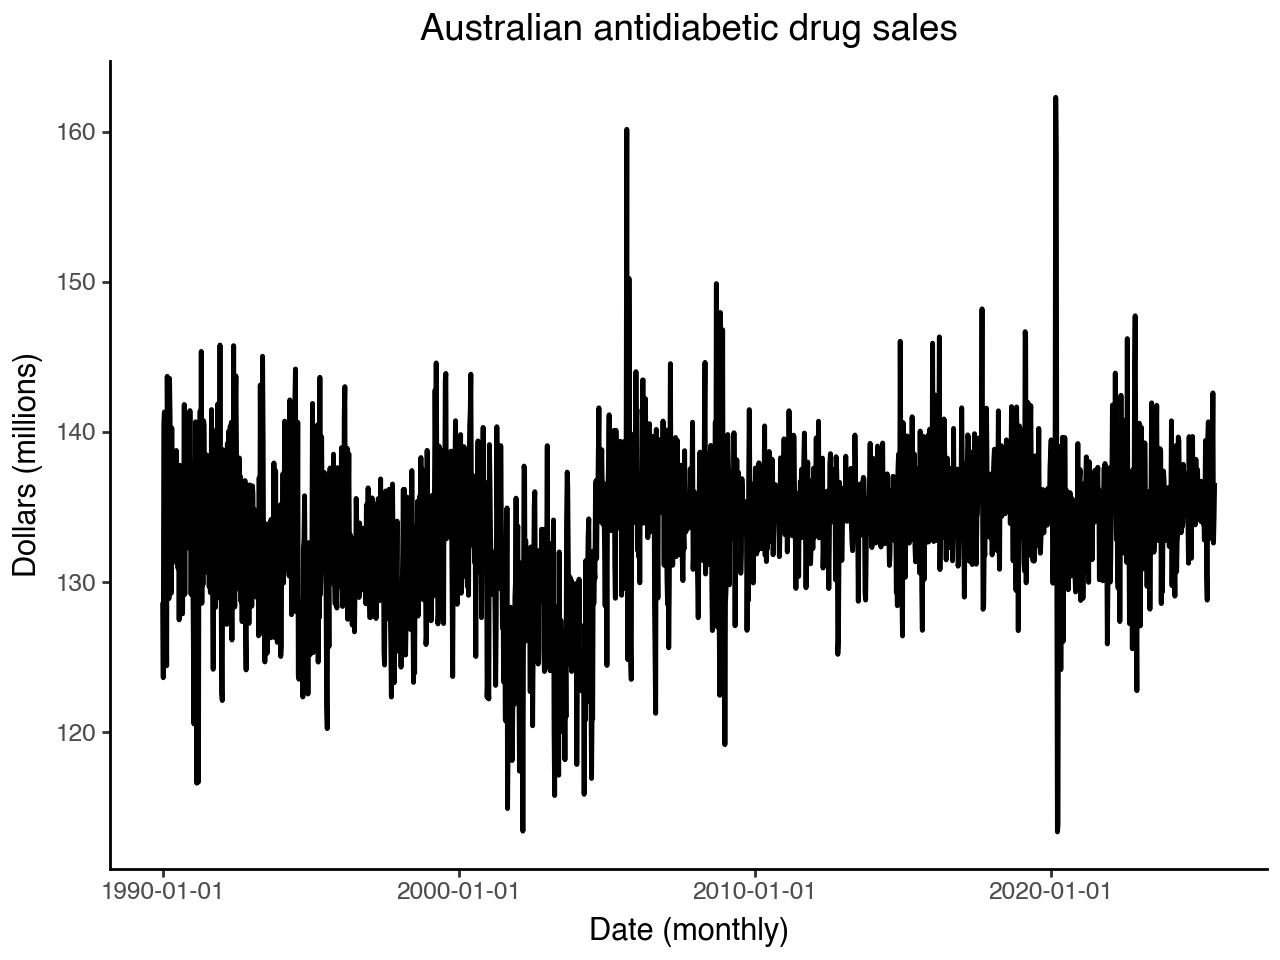

In [ ]:
df_toronto = preprocess(path='data/processed/data_toronto_proc.csv', 
                        var_date='Date')

(ggplot(data=df_toronto, mapping=aes(x='Date', y='price_2025')) + 
  geom_line(size=1) + 
  labs(x='Date (monthly)', y="Dollars (millions)") + 
  ggtitle(title='Toronto gas prices ') + 
  theme_classic())



Code below downloads all data sets from Forecasting: Principles and Practice, the Pythonic Way.

In [97]:
import os
import re
import requests

DOWNLOAD_DIR = os.path.join("data", "raw")

if not os.listdir(DOWNLOAD_DIR):
    print("Directory is empty → downloading datasets...")

    BASE_URL = "https://otexts.com/fpppy/data/"
    DOWNLOAD_DIR = os.path.join("data", "raw")
    os.makedirs(DOWNLOAD_DIR, exist_ok=True)

    # Craft headers to mimic a browser
    HEADERS = {
        'User-Agent': (
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
            'AppleWebKit/537.36 (KHTML, like Gecko) '
            'Chrome/115.0.5790.110 Safari/537.36'
        )
    }

    # 1. Fetch the data listing page with browser-like headers
    resp = requests.get(BASE_URL, headers=HEADERS)
    resp.raise_for_status()
    html = resp.text

    # 2. Extract CSV (and ZIP) filenames
    filenames = sorted(set(re.findall(r'([A-Za-z0-9_\-]+\.csv)', html)))
    filenames.insert(0, "data.zip")  # include the ZIP archive if present

    # 3. Download each file
    for fname in filenames:
        url = BASE_URL + fname
        dest = os.path.join(DOWNLOAD_DIR, fname)
        if os.path.exists(dest):
            print(f"Skipping (already exists): {fname}")
            continue
        print(f"Downloading {fname} ...")
        r = requests.get(url, headers=HEADERS, stream=True)
        try:
            r.raise_for_status()
            with open(dest, "wb") as f:
                for chunk in r.iter_content(8192):
                    f.write(chunk)
            print(f" → Downloaded: {fname}")
        except requests.HTTPError as e:
            print(f"  ! Download failed ({e})")


# 3. Time series decomposition


## 3.1. Transformations and adjustments

Following adjustments are often made to remove sources of variation that could obfuscate analyses 

1. Calendar adjusments. Calendar effects (such as variability in selling days per month) can masquerade as seasonal effects. Therefore, data are convereted to per diem format. 
2. Population adjustments: Use per-capita variables. 
3. Mathematical transformations: Useful if variability changes over time. Some useful transformations: 
    a. Log transformations: Increase in 1 unit corresponds to multiplication of 10 on original scale. 
    b. **Box-Cox** transformations: 
$$
w_t = \begin{cases}
\log(y_t) \hspace{0.5cm} \text{if } \lambda = 0 \\
\frac{(sign(y_t) |y_t|^\lambda - 1)}{\lambda}  \hspace{0.5cm} \text{otherwise} 
\end{cases}
$$

Note that logarithm is always natural in Box-Cox. If $\lambda$=1, then $w_t = y_t - 1$. A good value for $\lambda$ makes the size of seasonal changes roughly similar (hence keeing variability constant). 

Code below provides an example of applying a Box-Cox transformation using the Guerrero method to Australian gas production data. Briefly, this methdo computes a value of $\lambda$ that minimizes variability in variances across blocks of points (in this case, 4 seasons). 

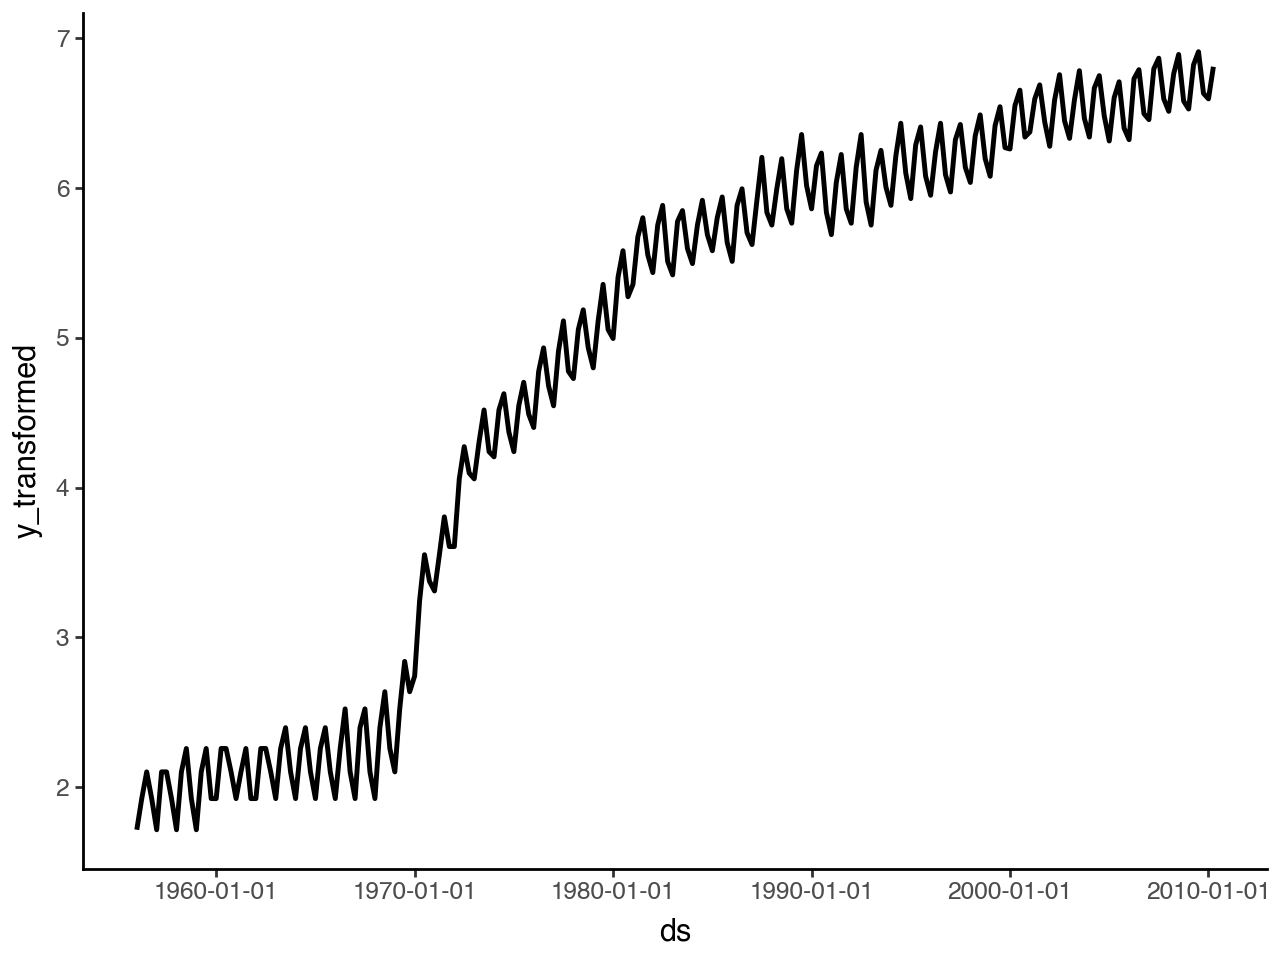

In [7]:
df_aus_prod = pd.read_csv("data/raw/aus_production.csv", 
                             parse_dates=["ds"])

df_aus_prod.insert(0, "unique_id", "Gas")
df_aus_prod.rename(columns={"Gas": "y"}, inplace=True)

optim_lambda = boxcox_lambda(df_aus_prod["y"].to_numpy(), 
                             method="guerrero",
                             season_length=4)

df_aus_prod["y_transformed"]  = boxcox(df_aus_prod["y"].to_numpy(), optim_lambda)

(ggplot(data=df_aus_prod, mapping=aes(x='ds', y='y_transformed')) + 
 geom_line(size=1) + 
 theme_classic())


## 3.2. Time series components

A simple decomposition views each $t$ time point in a time series as the sum of a seasonal ($S_t$), trend-cycle($T_t$), and residual ($R_t$) component: 

$$
y_t = S_t + T_t + R_t
$$

A multiplicative version also exists 

$$
y_t = S_t \times T_t \times R_t
$$

Additive decomposition suffices when magnitude of seasonal fluctuations and variation of trend-cycle does not vary over time. When variability in $S_t$ or $T_t$ depends on the level of the time series, multiplicative decomposition is more appropriate. Note that using logs also results in a multiplicative decomposition. 

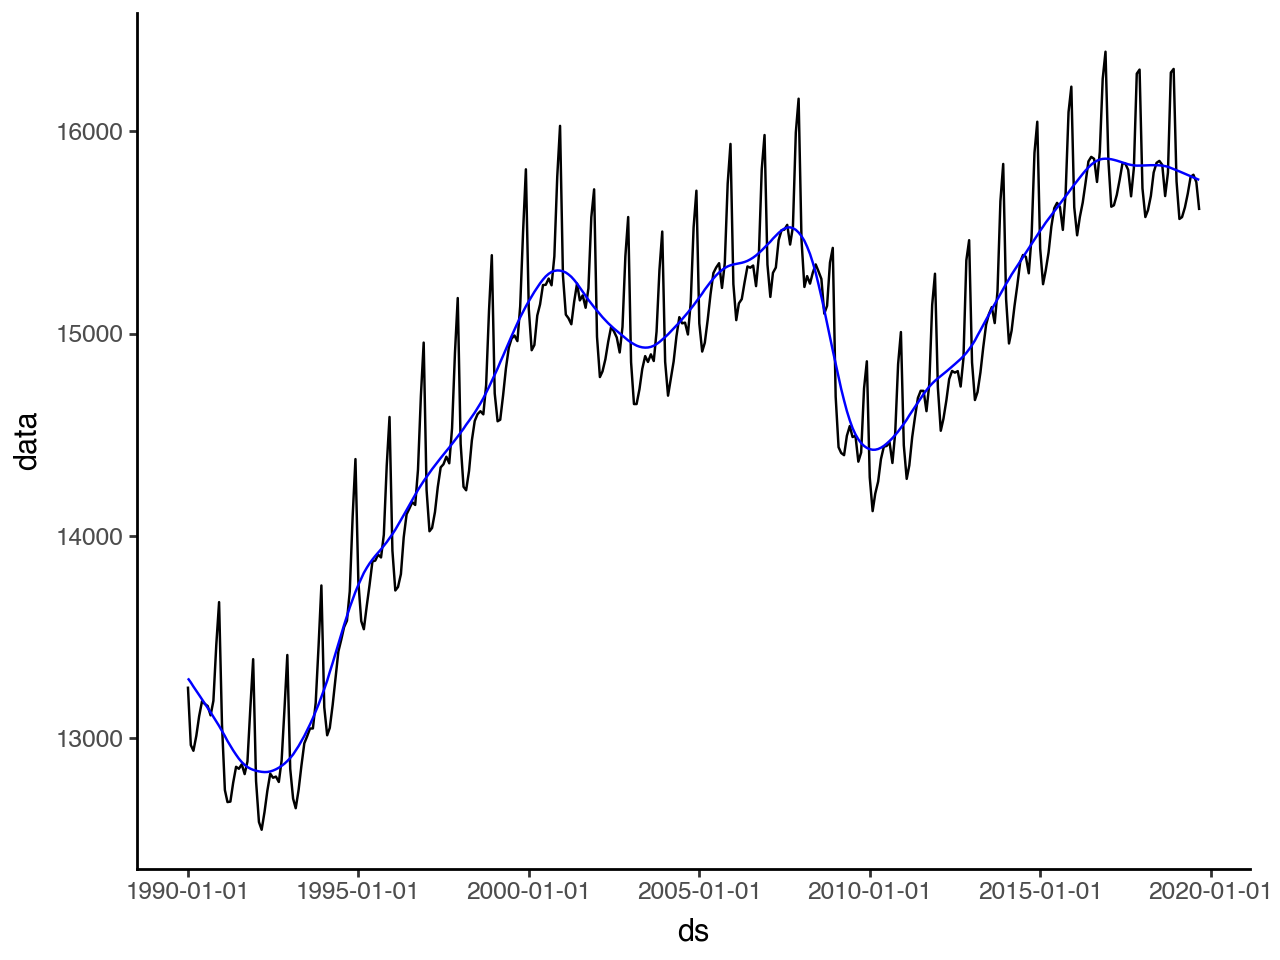

In [ ]:
# Example: Employment in the US retail sector
df_emp = pd.read_csv("data/raw/us_employment.csv", parse_dates=['ds'])
df_retail = df_emp.query('(unique_id == "Retail Trade") & (ds >= "1990-01-01")')

# run STL decomposition 
stl = STL(df_retail["y"], period=12)
res = stl.fit()

df_result = pd.DataFrame({
    "ds": df_retail["ds"],
    "data": df_retail["y"],
    "trend": res.trend,
    "seasonal": res.seasonal,
    "remainder": res.resid
}).reset_index(drop=True)

# plot time series along with trend-cycle
(ggplot(data=df_result, mapping=aes(x='ds', y='data')) + 
 geom_line(color='black') + 
 geom_line(mapping=aes(y='trend'), color='blue') + 
 theme_classic())


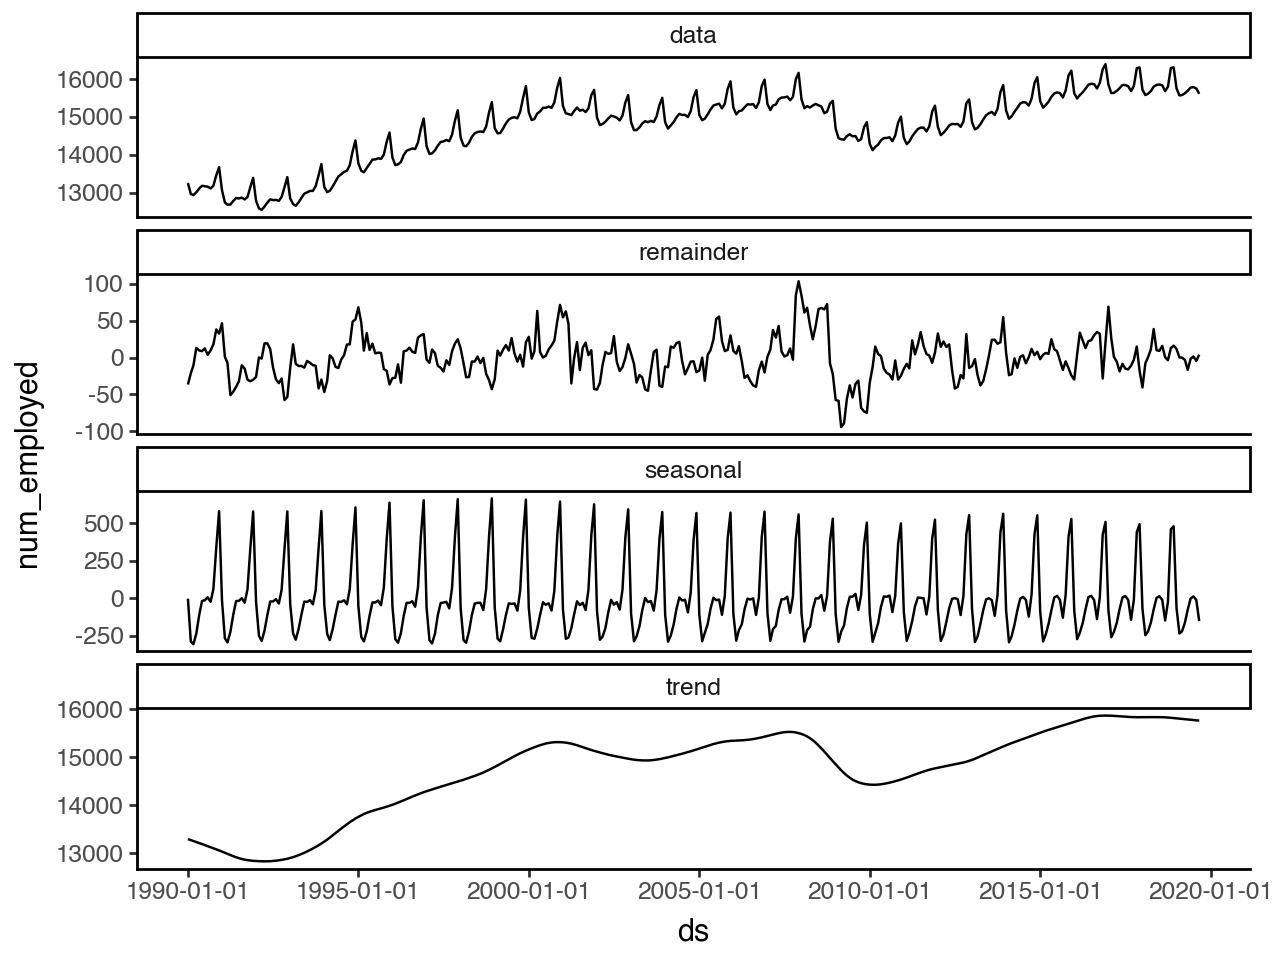

In [ ]:
df_long = pd.melt(frame=df_result, id_vars='ds', 
                  var_name='score_type', value_name='num_employed')

(ggplot(data=df_long, mapping=aes(x='ds', y='num_employed')) + 
 geom_line(color='black') + 
 facet_wrap(facets='~score_type', ncol=1, scales='free_y') + 
 theme_classic())

Note that, because employment data are affected by seasonal components (e.g., more job openings during holidays and fewer openings after holidays), removing the seasonal component (i.e., only looking at the trend-cycle) is more appropriate so that changes due to causes of interest can be observed. Tha

In [ ]:
# apply STL decomposition to weekly gas prices in toronto 
df_toronto = preprocess(path='data/processed/data_toronto_proc.csv', 
                        var_date='Date')


,Date,Fuel Type,city,price,year_month,date_ymw,value,cpi_2025,price_2025,month_txt,year,year_txt
0,1990-01-03,Regular Unleaded Gasoline,Toronto East/Est,48.7,1990-01,NaN,NaN,2.641711,128.651337,Jan,1990,1990
1,1990-01-10,Regular Unleaded Gasoline,Toronto East/Est,46.8,1990-01,NaN,NaN,2.641711,123.632086,Jan,1990,1990
2,1990-01-17,Regular Unleaded Gasoline,Toronto East/Est,53.2,1990-01,NaN,NaN,2.641711,140.539037,Jan,1990,1990
3,1990-01-24,Regular Unleaded Gasoline,Toronto East/Est,53.5,1990-01,NaN,NaN,2.641711,141.331551,Jan,1990,1990
4,1990-01-31,Regular Unleaded Gasoline,Toronto East/Est,52.6,1990-01,NaN,NaN,2.641711,138.954011,Jan,1990,1990
...,...,...,...,...,...,...,...,...,...,...,...,...
1850,2025-06-16,Regular Unleaded Gasoline,Toronto East/Est,138.2,2025-06,2025-06,197.6,1.000000,138.200000,Jun,2025,2025
1851,2025-06-23,Regular Unleaded Gasoline,Toronto East/Est,142.6,2025-06,2025-06,197.6,1.000000,142.600000,Jun,2025,2025
1852,2025-06-30,Regular Unleaded Gasoline,Toronto East/Est,132.6,2025-06,2025-06,197.6,1.000000,132.600000,Jun,2025,2025
1853,2025-07-07,Regular Unleaded Gasoline,Toronto East/Est,134.2,2025-07,NaN,NaN,1.000000,134.200000,Jul,2025,2025


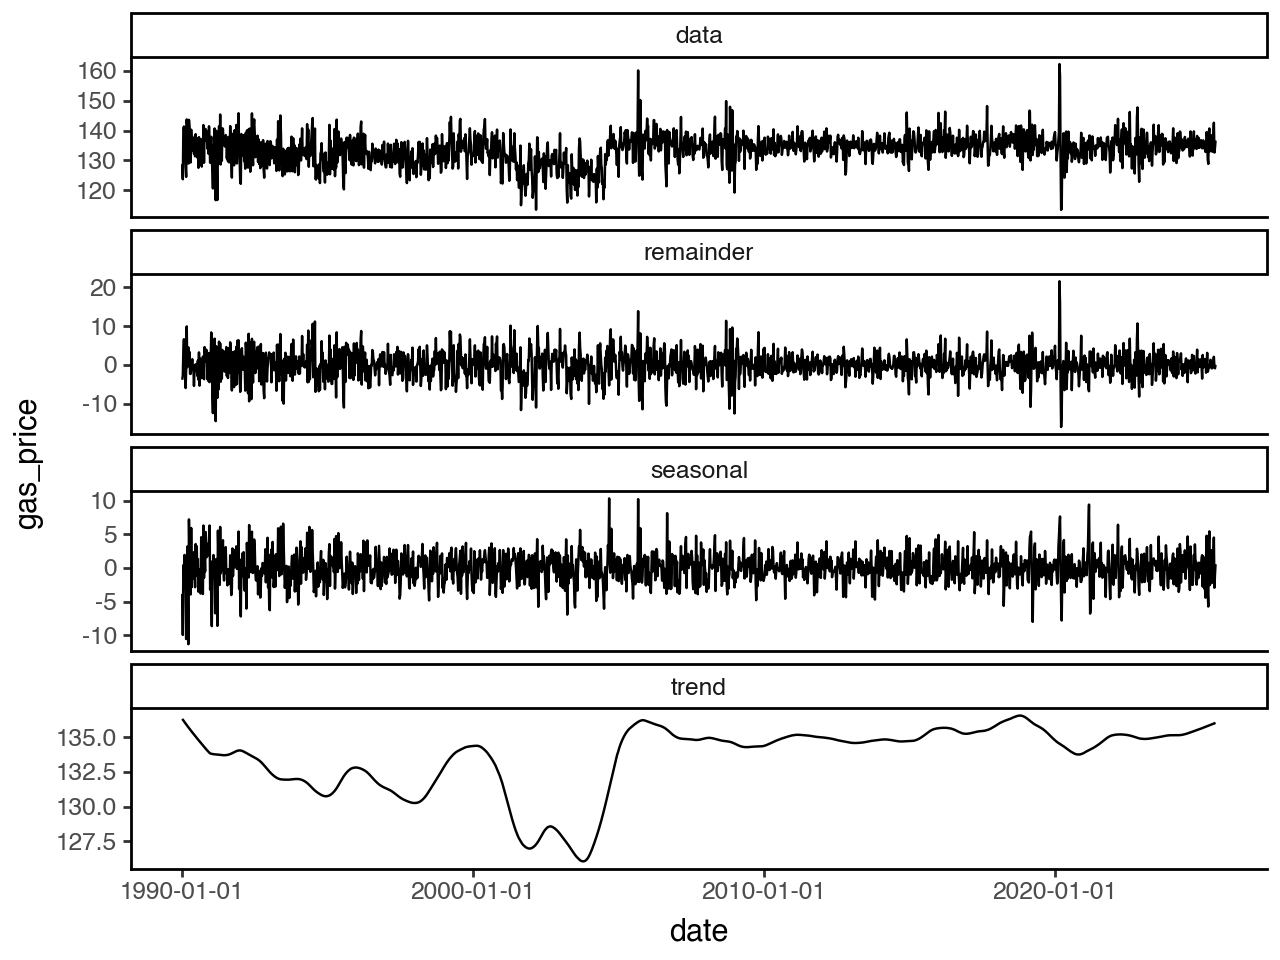

In [37]:
# run STL decomposition 
# NOTE: period argument indicates the number of observations that constitute an entire season. With weekly data, 
# the value would be 52
stl = STL(df_toronto["price_2025"], period=52)
res = stl.fit()

df_result = pd.DataFrame({
    "date": df_toronto["Date"],
    "data": df_toronto["price_2025"],
    "trend": res.trend,
    "seasonal": res.seasonal,
    "remainder": res.resid
}).reset_index(drop=True)

df_long = pd.melt(frame=df_result, id_vars='date', 
                  var_name='score_type', value_name='gas_price')


(ggplot(data=df_long, mapping=aes(x='date', y='gas_price')) + 
 geom_line(color='black') + 
 facet_wrap(facets='~score_type', ncol=1, scales='free_y') + 
 theme_classic())

## 3.3 Moving averages

More refined method is to used weighted moving averages. This minimizes the effects of outliers and also results in a smoother curve. 

$$
\hat{T}_t \sum_{j=-k}^k a_j y_{t+j}
$$

where $k=(m-1)/2$ and the weights are provided by $a_{-k}, ..., a_k$. 

### Moving averages of moving averages

A smoother curve results from applying a moving average of a moving averages. For example, a 2x4m-MA is applied on data of Australian beer production such that  

$$
\begin{align}
\hat{T}_t &= \frac{1}{2} \Big[ \frac{1}{4} (y_{t-2} + y_{t-1} + y_{t} + y_{t-1}) + \frac{1}{4} (y_{t-1} + y_{t} + y_{t+1} + y_{t+2}) \Big] \\ 
&= \frac{1}{8} y_{t-2} + \frac{1}{4} y_{t-1} + \frac{1}{4} y_{t} + \frac{1}{8} y_{t+1} \frac{1}{8} y_{t+2}
\end{align}
$$

As evident from above, each observatin is centered such that it is influenced equivalent by previous and consequent values. In a 2x4m-MA series, the first value corresponds to a moving average centered on the 3rd observation. 

### Estimating the trend-cycle with seasonal data

Trend-cycle components can be estimated using the 2xm-MA method. As an example, previously a 2x4-MA method was used for quarterly Australian beer produciton. Seasonal variation should largely be removed because time periods before and after the central time period are given equal weight. 

In general, a $2 \times m$-MA method is equivalent to a weighted moving average of order $m+1$ where all observations (except the first and last) take weight 1/m and the first and last observations are weighted by 1/2m. 

If an incorrect value is used for a moving average, the trend-cycle estimate could be contaminated by the seasonality of the data. 

In [49]:
# NOTE: data likely need to be shifted one time point back to make sense
df_beer = pd.read_csv('data/raw/aus_production.csv')

df_beer = df_beer.query('ds >= "1992-01-01"')[["ds", "Beer"]].copy()
df_beer.insert(0, "unique_id", "beer")
df_beer.rename(columns={"Beer": "y"}, inplace=True)

df_beer["4-MA"] = df_beer["y"].rolling(window=4, center=True).mean()
df_beer["2x4-MA"] = df_beer["4-MA"].rolling(window=2, center=True).mean().shift(-1)
df_beer.head()


,unique_id,ds,y,4-MA,2x4-MA
144,beer,1992-01-01,443,NaN,NaN
145,beer,1992-04-01,410,NaN,NaN
146,beer,1992-07-01,420,451.25,450.000
147,beer,1992-10-01,532,448.75,450.125
148,beer,1993-01-01,433,451.50,450.250


/opt/miniconda3/lib/python3.13/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 2 rows containing missing values.


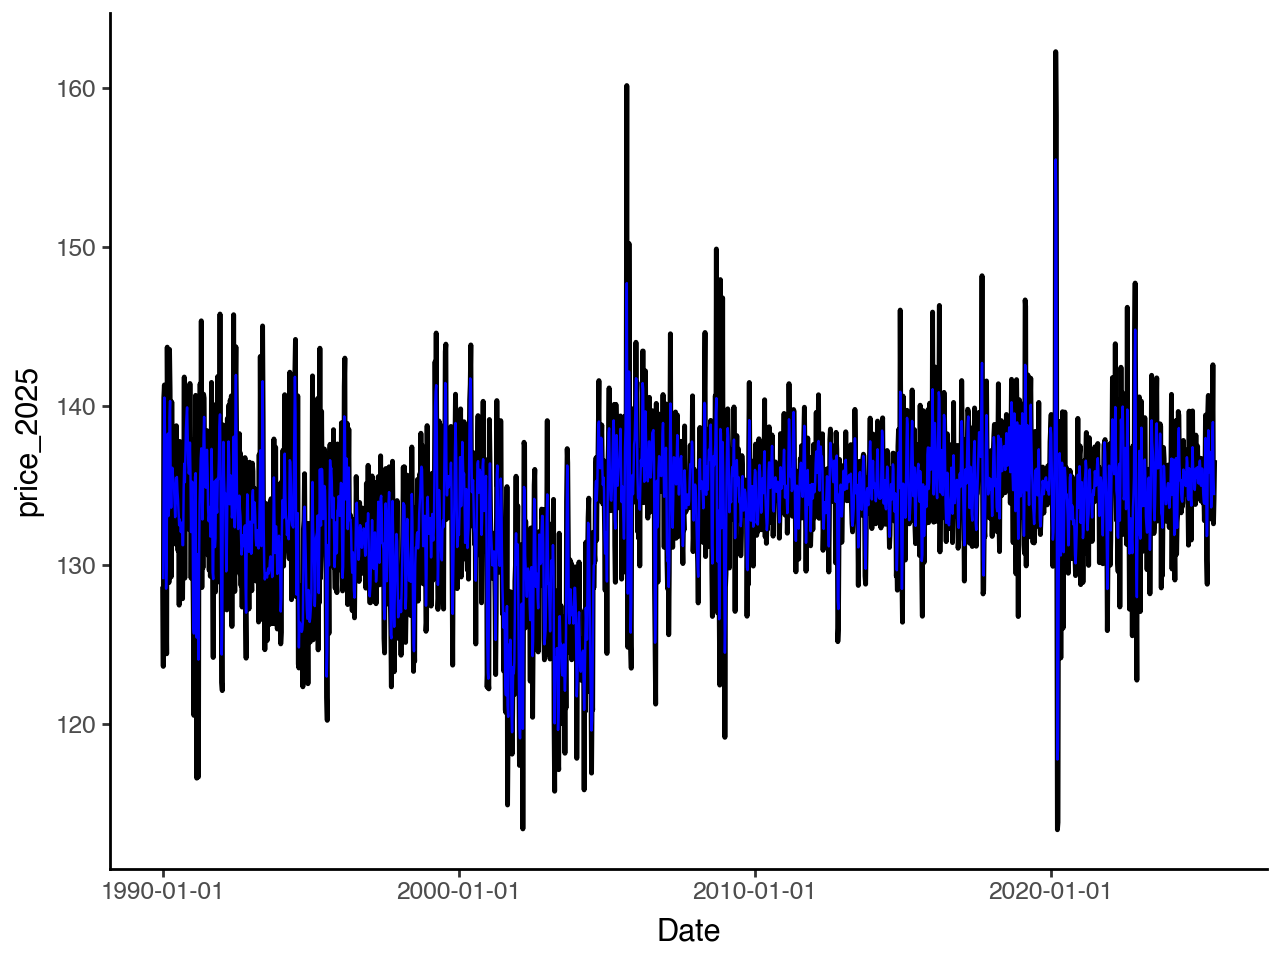

In [58]:
# Example: Weekly gas prices using 2x2-MA 
df_toronto = preprocess(path='data/processed/data_toronto_proc.csv', 
                        var_date='Date')

df_toronto["2-MA"] = df_toronto["price_2025"].rolling(window=2, center=True).mean()
df_toronto["2x2-MA"] = df_toronto["2-MA"].rolling(window=2, center=True).mean().shift(-1)

(ggplot(data=df_toronto, mapping=aes(x='Date', y='price_2025')) + 
       geom_line(size=1) + 
       geom_line(color='blue', mapping=aes(x='Date', y='2x2-MA')) + 
       theme_classic())


## 3.4. Classical decomposition 

Early method of time series decomposition. Has an additive and multiplicative form. Assumes seasonal component is constant. Below explanation applies to case with seasonal period $m$ (e.g., $m=4$ for quarterly data, $m=12$ for monthly data, $m=7$ for daily data). 

**Additive decomposition**
1. If $m$ is event, compute trend-cycle using 2 x m-MA. If $m$ is odd, compute $\hat{T}_t$ using m-MA. As an example, if we have monthly data (m=12), then 24 values would go into the moving average. 
2. Calculate the detrended series: $y_t - \hat{T}_t$. 
3. Use detrended values to estimate seasonal components. As an example, with monthly data, the seasonal component would be estimated by computing the average detrended value in given month. Importantly, seasonal components are adjusted such that they sum to zero. This constraint is important because it ensures that a unique solution is obtained for the decomposition. 
4. Compute remainder. 

### Comments on classical decomposition

Classical decomposition has the following limitations:

1. Trend-cycle estimates are unavailable for the first and last few observations. 
2. Trend-cycle estimate place too little weight on rapid changes.
3. Assume seasonal component is constant over time. THis becomes unreasonable over longer periods of time. 
4. Unable to model sudden changes (e.g., labour dispute leading to sudden termination of activity)

## 3.5. Methods used by official statistics agencies 




